# Part 1: RL Environment

In [1]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install gymnasium matplotlib numpy optuna
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
import optuna
from collections import defaultdict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.8 MB/s eta 0:00:00


In [3]:
ACTION_LOOKUP= {0: 'Down', 1: 'Up', 2: 'Right', 3: 'Left'}

AGENT_POS= [0, 3]
STAR_POS= [1, 0]
MASHROOM_POS= [3, 2]
BOO_POS= [1, 1]
BOMB_POS= [2, 2]
GOAL_POS= [3, 0]

In [4]:
STATE_LOCATION = {(i, j): k for k, (i, j) in enumerate([(i, j) for i in range(4) for j in range(4)])}

In [5]:
class SuperMarioEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):

        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 50

        self.timestep = 0

        self.agent_pos = AGENT_POS.copy()
        self.goal_pos = GOAL_POS.copy()
        self.star_pos = STAR_POS.copy()
        self.mashroom_pos = MASHROOM_POS.copy()
        self.boo_pos = BOO_POS.copy()
        self.bomb_pos = BOMB_POS.copy()


        self.star_awarded, self.mashroom_awarded,self.boo_awarded,self.bomb_awarded = False,False,False,False

        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.star_pos)] = 6
        self.state[tuple(self.mashroom_pos)] = 5
        self.state[tuple(self.boo_pos)] = -3
        self.state[tuple(self.bomb_pos)] = -6
        self.state[tuple(self.goal_pos)] = 10



        self.goal_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/princess.jpeg')

        self.agent_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/mario.png')

        self.star_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/mario-star.jpeg')
        self.mashroom_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/mashroom.png')
        self.boo_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/boo.jpeg')
        self.bomb_img = plt.imread('/content/drive/My Drive/ML Assignment 3/Images/bomb.jpeg')

        
    def reset(self, **kwargs):

        self.timestep = 0
        
        self.agent_pos = AGENT_POS.copy()
        self.goal_pos = GOAL_POS.copy()
        self.star_pos = STAR_POS.copy()
        self.mashroom_pos = MASHROOM_POS.copy()
        self.boo_pos = BOO_POS.copy()
        self.bomb_pos = BOMB_POS.copy()

        self.star_awarded, self.mashroom_awarded,self.boo_awarded,self.bomb_awarded = False,False,False,False

        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.star_pos)] = 6
        self.state[tuple(self.mashroom_pos)] = 5
        self.state[tuple(self.boo_pos)] = -3
        self.state[tuple(self.bomb_pos)] = -6
        self.state[tuple(self.goal_pos)] = 10

        observation = self.state.flatten()

        info = {}

        return observation, info, STATE_LOCATION[tuple(self.agent_pos)]
    
    def step(self, action):

        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
          self.agent_pos[0] -= 1
        if action == 2:
          self.agent_pos[1] += 1
        if action == 3:
          self.agent_pos[1] -= 1

        
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.star_pos)] = 6
        self.state[tuple(self.mashroom_pos)] = 5
        self.state[tuple(self.boo_pos)] = -3
        self.state[tuple(self.bomb_pos)] = -6
        self.state[tuple(self.goal_pos)] = 10

        observation = self.state.flatten()
        
        reward = 0
        if (self.agent_pos == self.star_pos).all():
          if not self.star_awarded:
            reward += 6
            self.star_awarded = True
        if (self.agent_pos == self.mashroom_pos).all():
          if not self.mashroom_awarded:
            reward += 5
            self.mashroom_awarded = True
        
        if (self.agent_pos == self.boo_pos).all():

          if not self.boo_awarded:
            reward -= 5
            self.boo_awarded = True
        
        if (self.agent_pos == self.bomb_pos).all():
          if not self.bomb_awarded:
            reward -= 6
            self.bomb_awarded = True
        
        if (self.agent_pos == self.goal_pos).all():
          reward += 10
        
        #print(reward)
        
        self.timestep += 1

        terminated = True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
        
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

        info = {}
        
        #return observation, reward, terminated, truncated, info, self.agent_pos

        return STATE_LOCATION[tuple(self.agent_pos)],reward, terminated, info, self.agent_pos
        
    def render(self):

        #plt.imshow(self.state)
        fig, ax = plt.subplots()

        
        ax.imshow(self.agent_img, extent=[self.agent_pos[1], self.agent_pos[1]+1, self.state.shape[0]-self.agent_pos[0]-1, self.state.shape[0]-self.agent_pos[0]])

        ax.imshow(self.goal_img, extent=[self.goal_pos[1], self.goal_pos[1]+1, self.state.shape[0]-self.goal_pos[0]-1, self.state.shape[0]-self.goal_pos[0]])

        if not self.star_awarded:
          ax.imshow(self.star_img, extent=[self.star_pos[1], self.star_pos[1]+1, self.state.shape[0]-self.star_pos[0]-1, self.state.shape[0]-self.star_pos[0]])
        if not self.mashroom_awarded:
          ax.imshow(self.mashroom_img, extent=[self.mashroom_pos[1], self.mashroom_pos[1]+1, self.state.shape[0]-self.mashroom_pos[0]-1, self.state.shape[0]-self.mashroom_pos[0]])
        if not self.boo_awarded:
          ax.imshow(self.boo_img, extent=[self.boo_pos[1], self.boo_pos[1]+1, self.state.shape[0]-self.boo_pos[0]-1, self.state.shape[0]-self.boo_pos[0]])
        if not self.bomb_awarded:
          ax.imshow(self.bomb_img, extent=[self.bomb_pos[1], self.bomb_pos[1]+1, self.state.shape[0]-self.bomb_pos[0]-1, self.state.shape[0]-self.bomb_pos[0]])


        
        ax.set_xlim([0, self.state.shape[1]])
        ax.set_ylim([0, self.state.shape[0]])
        plt.show()

In [6]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    return np.random.choice(self.action_space.n)

## Running an Episode

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

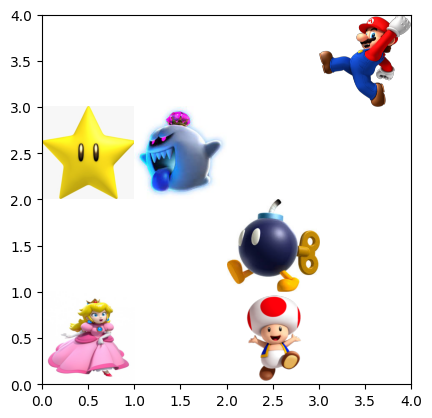

<IPython.core.display.Javascript object>

[0 3] Up 0


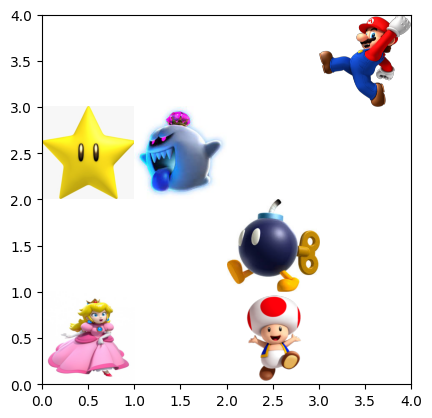

[0 3] Right 0


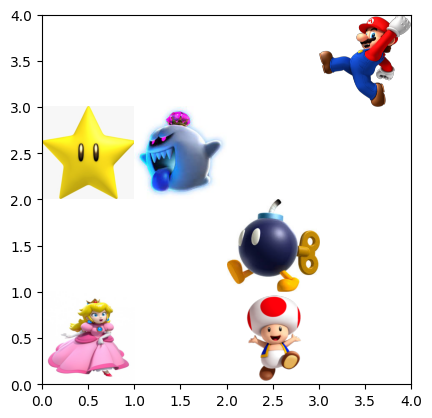

[1 3] Down 0


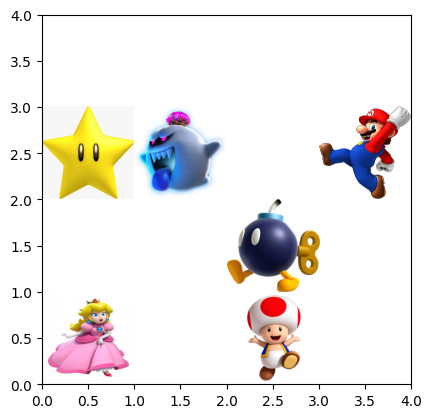

[1 3] Right 0


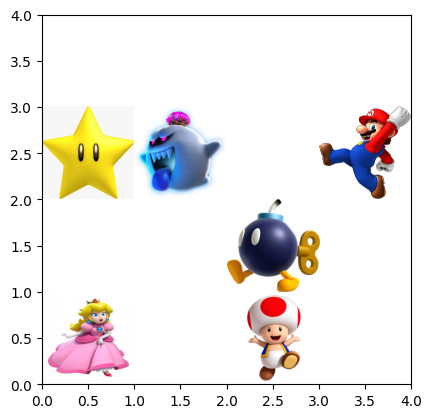

[2 3] Down 0


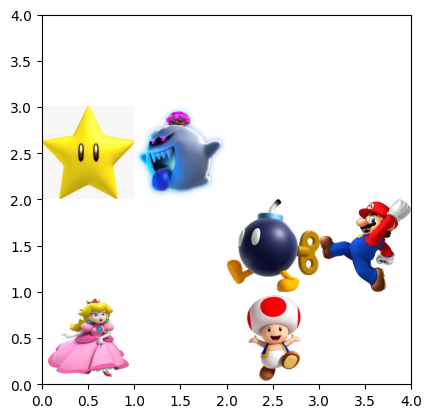

[2 2] Left -6


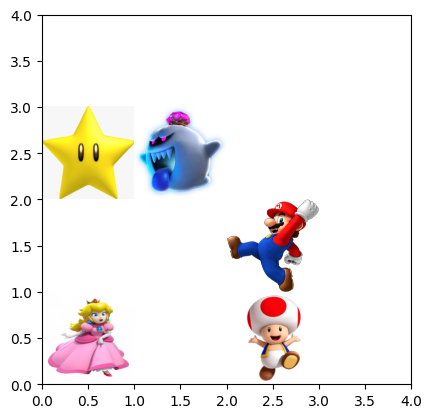

[1 2] Up 0


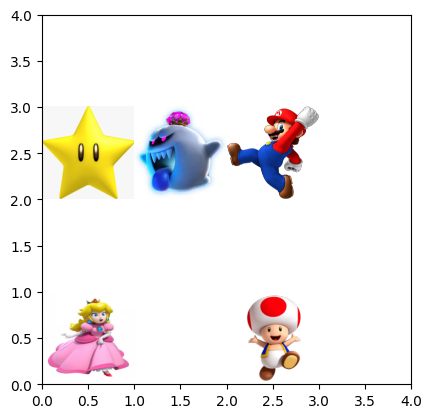

[2 2] Down 0


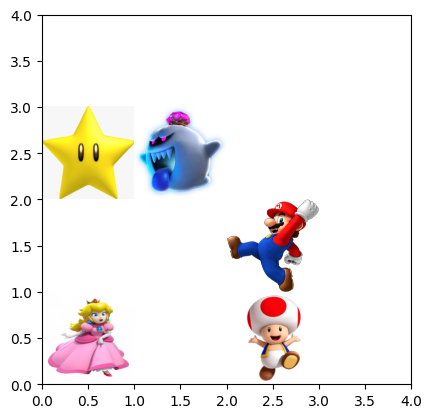

[1 2] Up 0


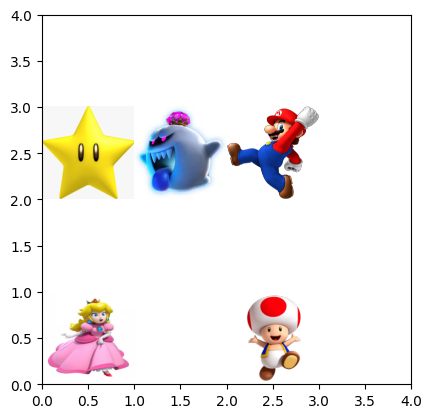

[1 1] Left -5


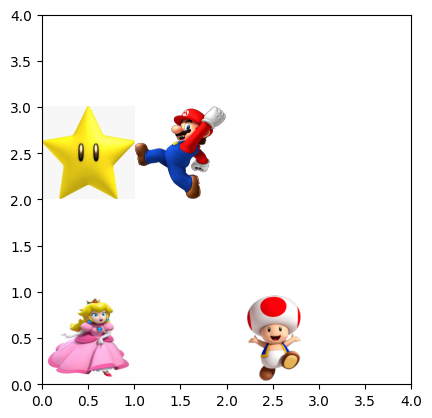

[1 2] Right 0


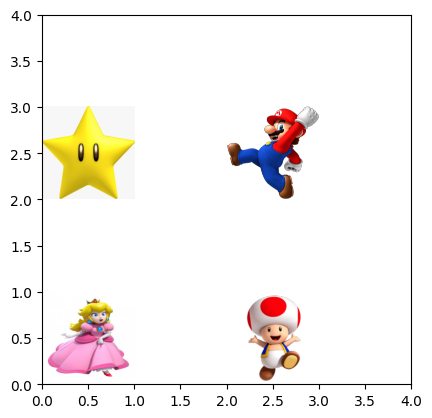

[1 3] Right 0


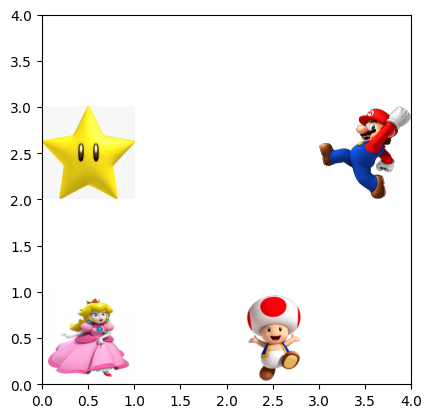

[1 3] Right 0


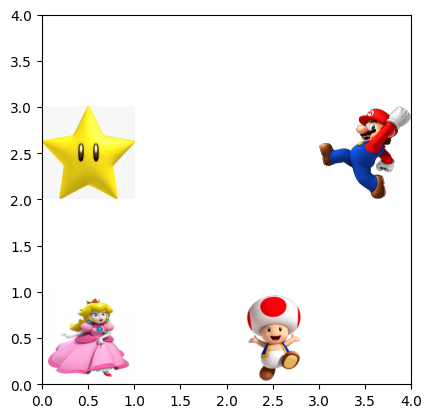

[1 2] Left 0


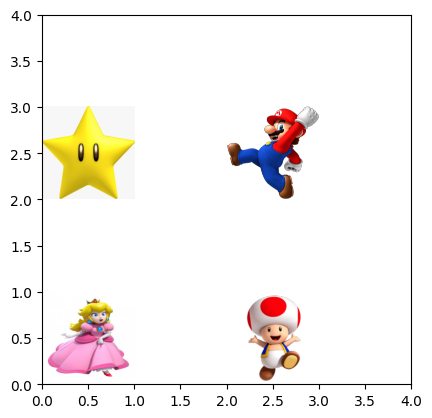

[1 3] Right 0


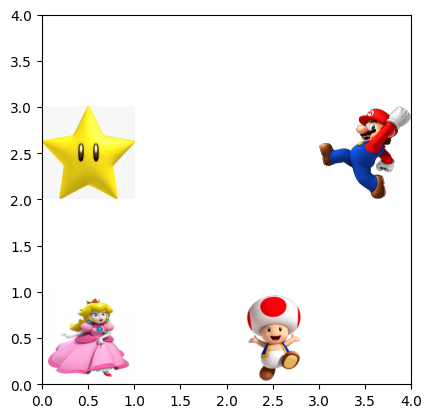

[1 3] Right 0


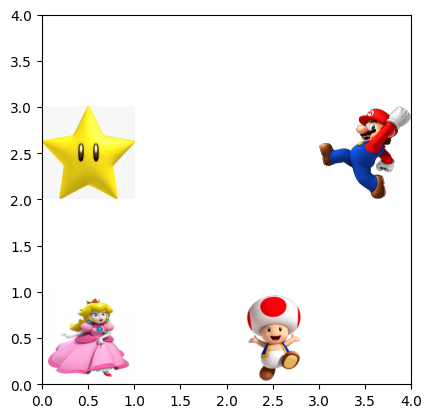

[2 3] Down 0


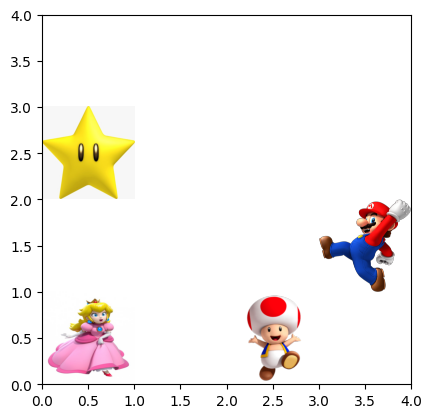

[3 3] Down 0


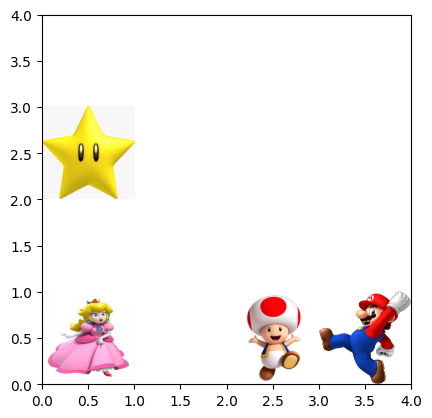

[2 3] Up 0


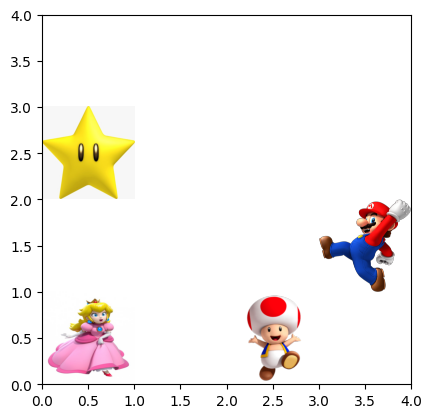

[3 3] Down 0


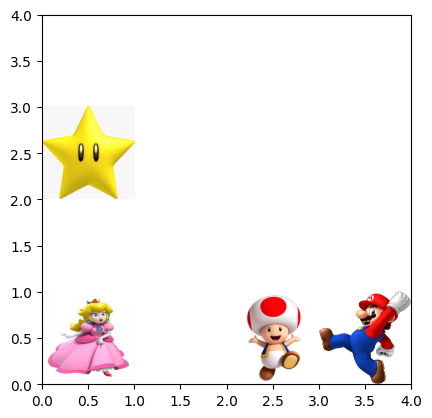

[3 3] Right 0


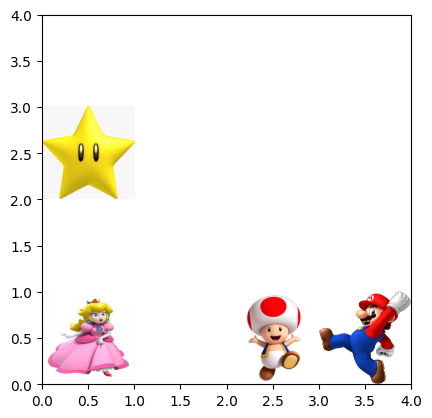

[3 2] Left 5


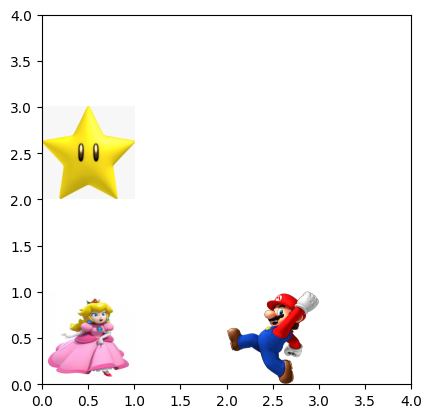

[3 2] Down 0


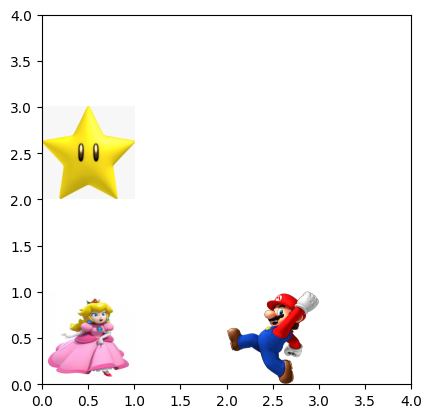

[3 2] Down 0


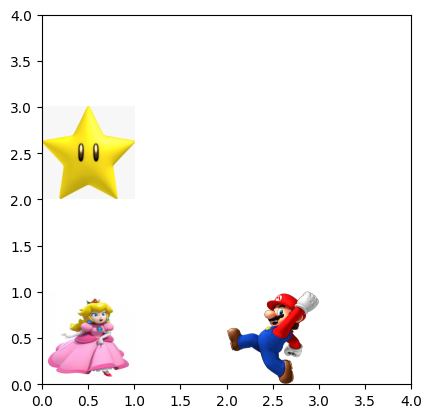

[3 2] Down 0


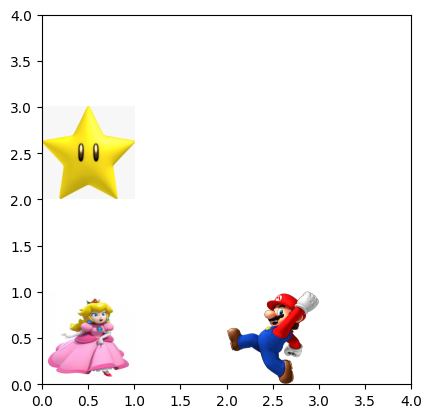

[3 1] Left 0


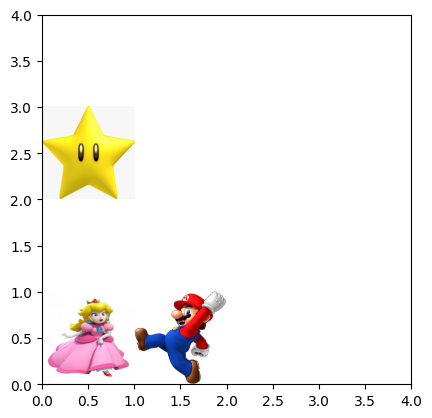

[3 2] Right 0


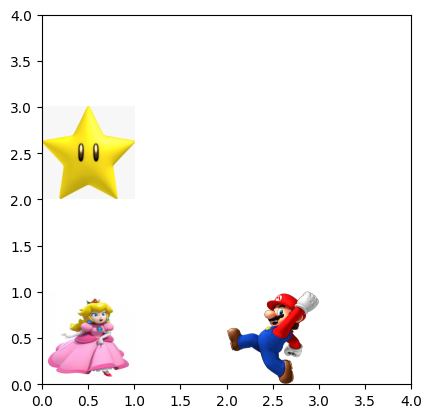

[3 2] Down 0


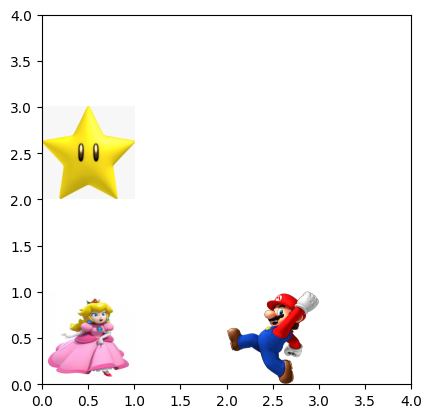

[3 3] Right 0


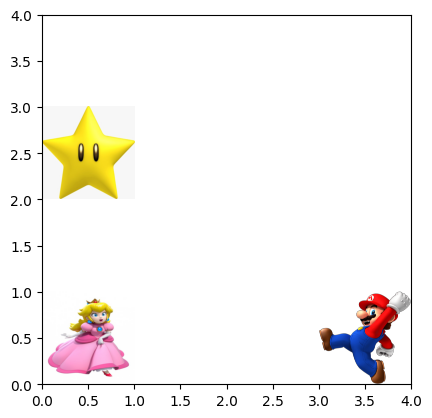

[3 3] Down 0


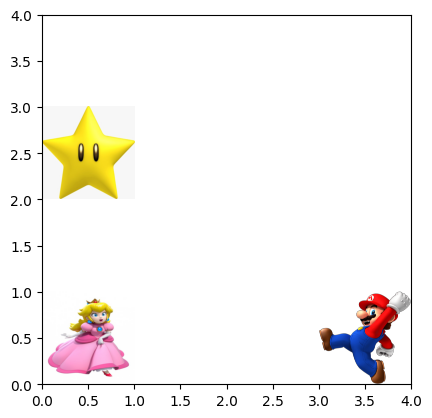

[3 2] Left 0


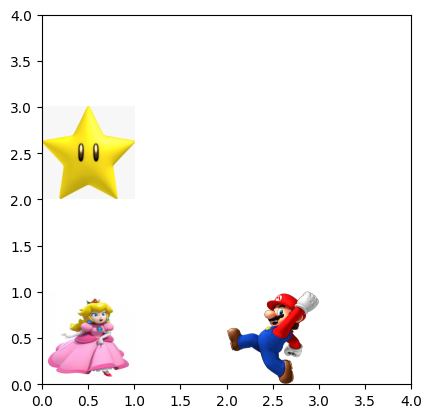

[3 1] Left 0


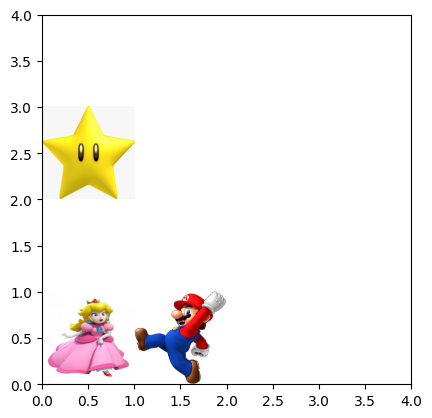

[3 2] Right 0


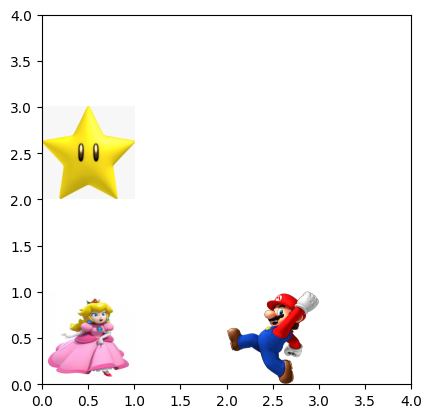

[2 2] Up 0


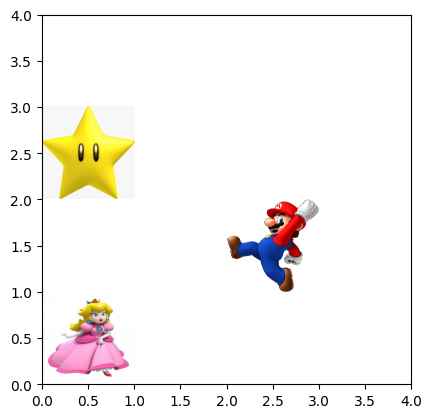

[2 3] Right 0


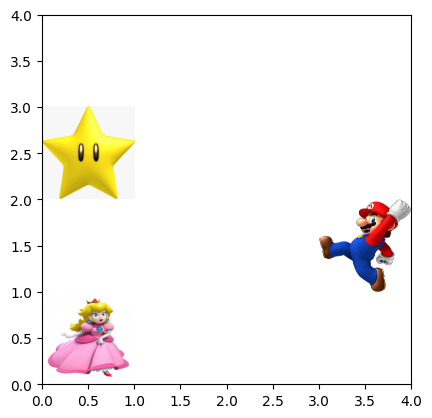

[1 3] Up 0


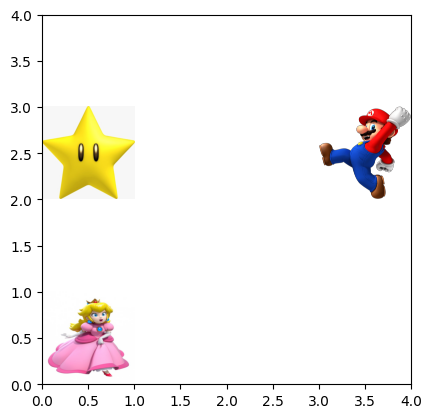

[1 3] Right 0


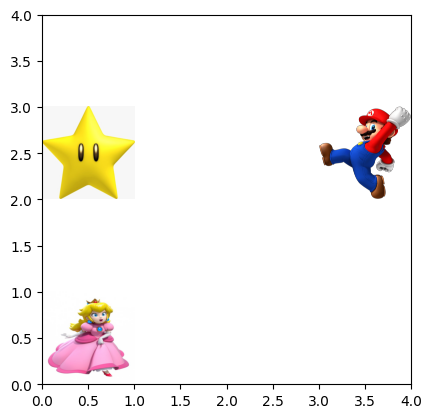

[2 3] Down 0


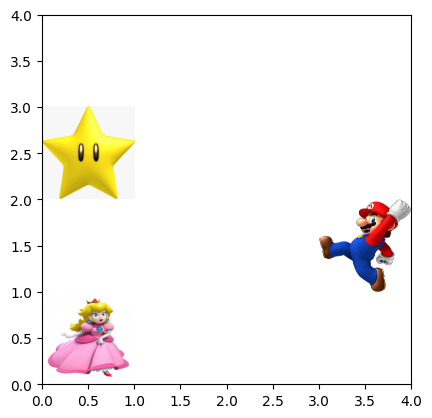

[2 3] Right 0


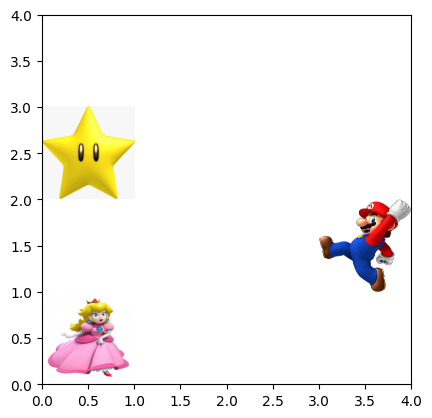

[2 3] Right 0


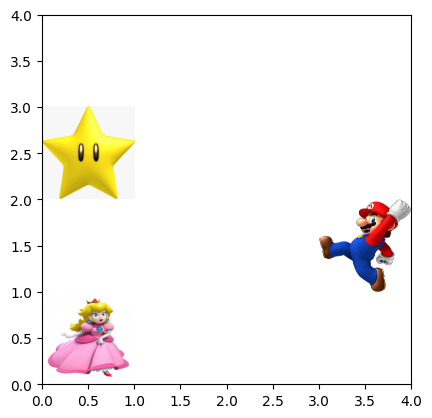

[1 3] Up 0


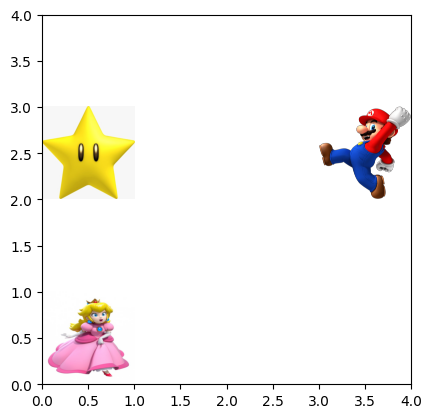

[0 3] Up 0


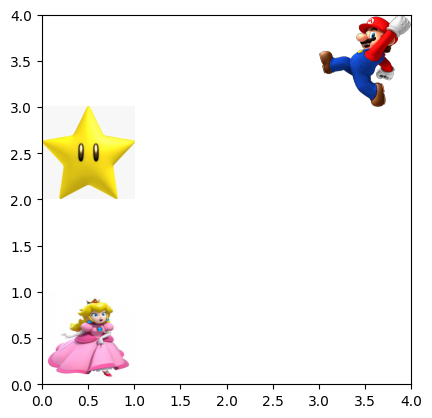

[0 3] Up 0


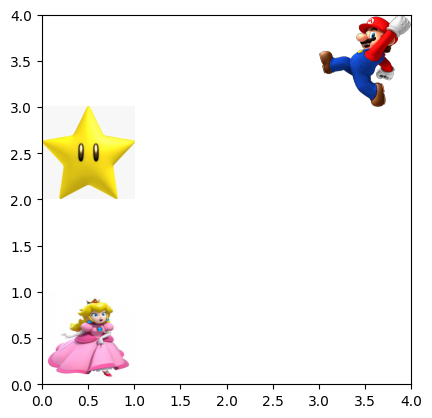

[1 3] Down 0


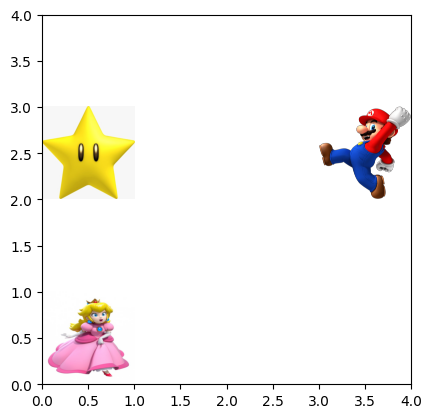

[1 2] Left 0


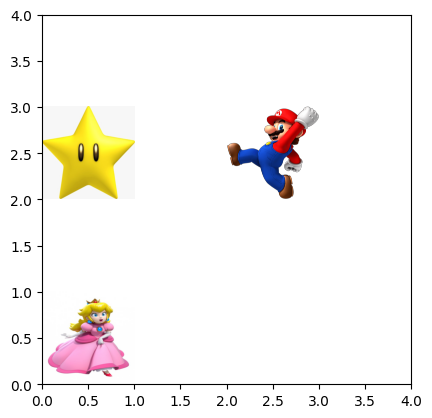

[0 2] Up 0


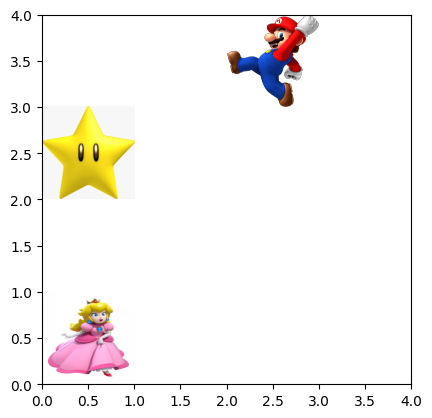

[0 2] Up 0


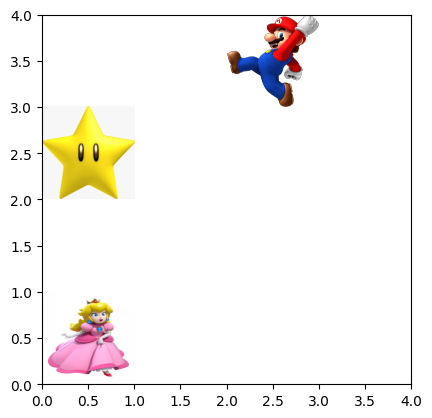

[0 3] Right 0


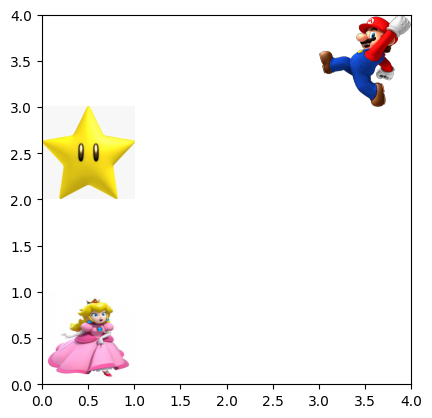

[1 3] Down 0


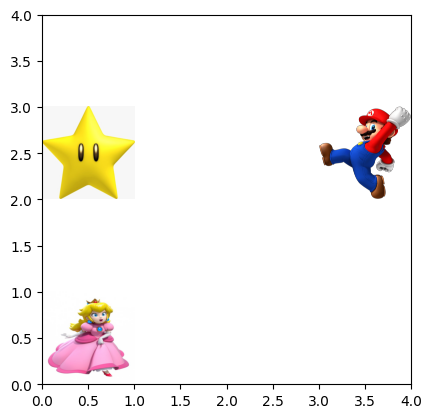

[1 2] Left 0


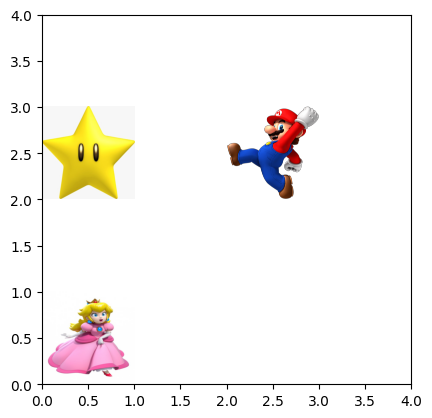

Episode:1 Score: -6


In [7]:
episode = 1
reward_list = []

for i in range(episode):
  env = SuperMarioEnvironment()
  agent = RandomAgent(env)

  obs, info, _ = env.reset()
  score = 0

  terminated, truncated = False, False
  output_grid = widgets.Grid(1, 1)
  with output_grid.output_to(0, 0):
    env.render()

  while not terminated:
    action = agent.step(obs)
    state, reward, terminated, info, agent_pos = env.step(action)
    score += reward
    #print(score)
    print(agent_pos, ACTION_LOOKUP[action], reward)
    #with output_grid.output_to(0, 0):
      # output_grid.clear_cell()
    env.render()
    time.sleep(1)
  print('Episode:{} Score: {}'.format(i+1, score))
  reward_list.append(score)

# Part 2: SARSA


In [8]:
class SARSA(RandomAgent):
    
    def __init__(self, env, discount_rate, learning_rate, epsilon):
        super().__init__(env)

        self.epsilon= epsilon
        self.gamma= discount_rate
        self.alpha= learning_rate
        self.Q = np.zeros((self.observation_space.n, self.action_space.n))

    def step(self, state:int):
        # action=0
        # if np.random.uniform(0, 1) < self.epsilon:
        #   action = env.action_space.sample()
        # else:
        #   action = np.argmax(self.Q[state, :])
        # return action

        Q_state= self.Q[state]
        #print(Q_state)
        greedy_action= np.argmax(Q_state)
        random_action= super().step(state)

        # Depending on the epsilon value greedy or random action is chosen
        return random_action if np.random.random() < self.epsilon else greedy_action

        
    def train(self, experience: tuple):
      state, action, next_state, next_action, reward, done= experience
      Q_next = self.Q[next_state, next_action] if not done else 0
      Q_value = reward + self.gamma * Q_next - self.Q[state, action]

      # next_Q = self.Q[next_state, next_action]
      # target = reward + self.gamma * next_Q * (1 - int(done))
      # error = target - self.Q[state, action]
      # self.Q[state, action] += self.alpha * error

      self.Q[state, action] += self.alpha * Q_value

      #Q_value = reward + self.gamma * Q_next - self.Q[state, action]

      #Q_value = reward + self.gamma * Q_next - self.Q[state, action]
      #self.Q[state, action] += self.alpha * Q_value
      
      if done:
        self.epsilon *= 0.99

In [9]:
configs = [
    {'episodes':500, 'discount_rate' : 0.9, 'learning_rate' : 0.1, 'epsilon':0.9},
    {'episodes':1000, 'discount_rate' : 0.95, 'learning_rate' : 0.1, 'epsilon':0.85},
    {'episodes':1200, 'discount_rate' : 0.99, 'learning_rate' : 0.1, 'epsilon':0.99}
]

## Setup 1

In [10]:

superMario = SuperMarioEnvironment()
SARSA_agent = SARSA(env= superMario, discount_rate = configs[0]['discount_rate'], learning_rate = configs[0]['learning_rate'], epsilon= configs[0]['epsilon'])

reached, not_reached, total_reward = 0, 0, 0

epsilon_decay_list = []
episode_reward_list = []
episode_timestep_list = []

for each_episode in range(configs[0]['episodes']):
  
  state = superMario.reset()[2]
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  action = SARSA_agent.step(state = state)
  while not done:
    next_state, reward, done, info, _= superMario.step(action = action)
    
    next_action= SARSA_agent.step(state= next_state)

    SARSA_agent.train(experience= (state, action, next_state, next_action, reward, done))
    state= next_state
    action= next_action

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1

  episode_timestep_list.append(timestep_per_episode)
  epsilon_decay_list.append(SARSA_agent.epsilon)
  episode_reward_list.append(reward_per_episode)

  if done == True and superMario.timestep < 50:
    reached += 1
  elif done == True and superMario.timestep == 50:
    not_reached += 1

print('Goal Reached: {} & Goal Not reached: {}'.format(reached, not_reached))
     

Goal Reached: 491 & Goal Not reached: 9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

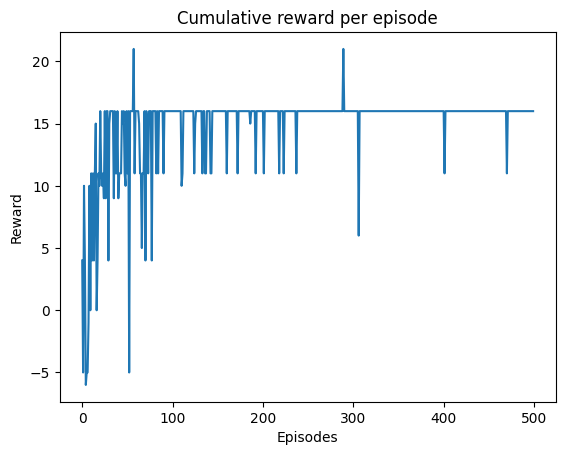

In [11]:
with output_grid.output_to(0, 0):
  plt.title('Cumulative reward per episode')
  plt.plot(episode_reward_list)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

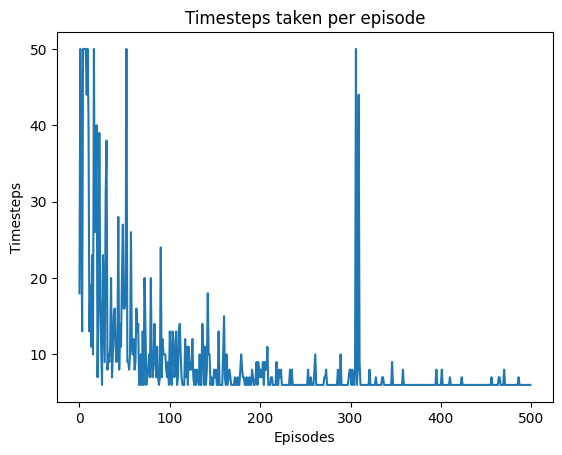

In [12]:
with output_grid.output_to(0, 0):
  plt.title('Timesteps taken per episode')
  plt.plot(episode_timestep_list)
  plt.xlabel('Episodes')
  plt.ylabel('Timesteps')

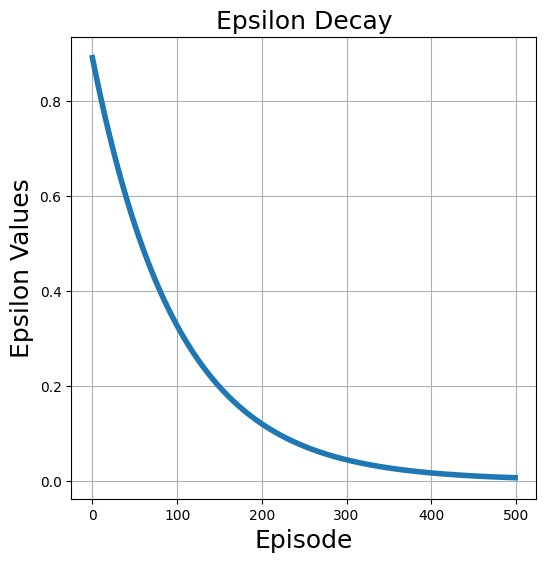

In [13]:
plt.figure(figsize=(6, 6))
plt.plot(epsilon_decay_list, linewidth=4)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Epsilon Values', fontsize=18)
plt.title('Epsilon Decay', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

## Setup 2

In [14]:
superMario1 = SuperMarioEnvironment()
SARSA_agent1 = SARSA(env= superMario1, discount_rate = configs[1]['discount_rate'], learning_rate = configs[1]['learning_rate'], epsilon= configs[1]['epsilon'])

reached, not_reached, total_reward = 0, 0, 0

epsilon_decay_list = []
episode_reward_list = []
episode_timestep_list = []

for each_episode in range(configs[1]['episodes']):
  
  state = superMario1.reset()[2]
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  action= SARSA_agent1.step(state = state)

  while not done:
    next_state, reward, done, info, _= superMario1.step(action = action)
    
    next_action= SARSA_agent1.step(state= next_state)

    SARSA_agent1.train(experience= (state, action, next_state, next_action, reward, done))
    state= next_state
    action= next_action

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1

  episode_timestep_list.append(timestep_per_episode)
  epsilon_decay_list.append(SARSA_agent1.epsilon)
  episode_reward_list.append(reward_per_episode)

  if done == True and superMario1.timestep < 50:
    reached += 1
  elif done == True and superMario1.timestep == 50:
    not_reached += 1

print('Goal Reached: {} & Goal Not reached: {}'.format(reached, not_reached))
     

Goal Reached: 993 & Goal Not reached: 7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

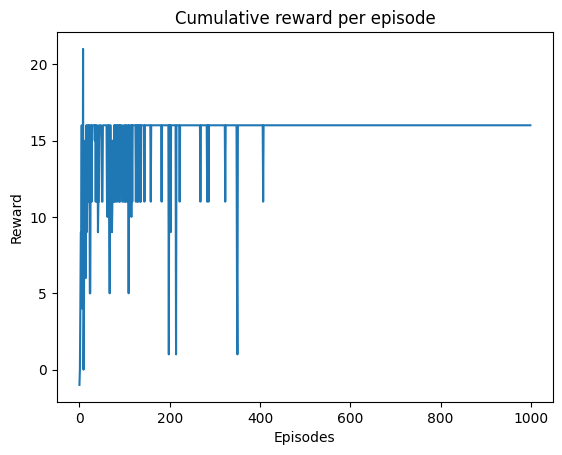

In [15]:
with output_grid.output_to(0, 0):
  plt.title('Cumulative reward per episode')
  plt.plot(episode_reward_list)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

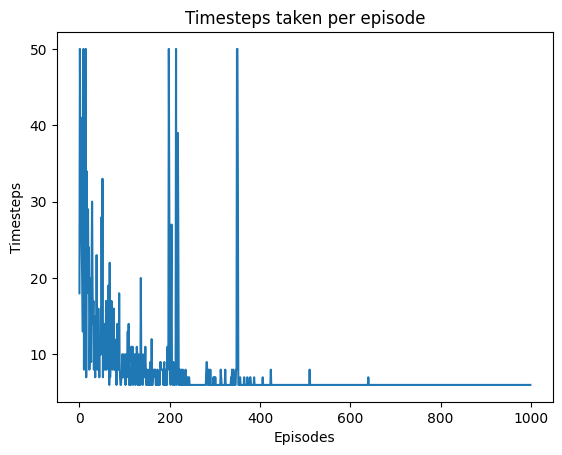

In [16]:
with output_grid.output_to(0, 0):
  plt.title('Timesteps taken per episode')
  plt.plot(episode_timestep_list)
  plt.xlabel('Episodes')
  plt.ylabel('Timesteps')

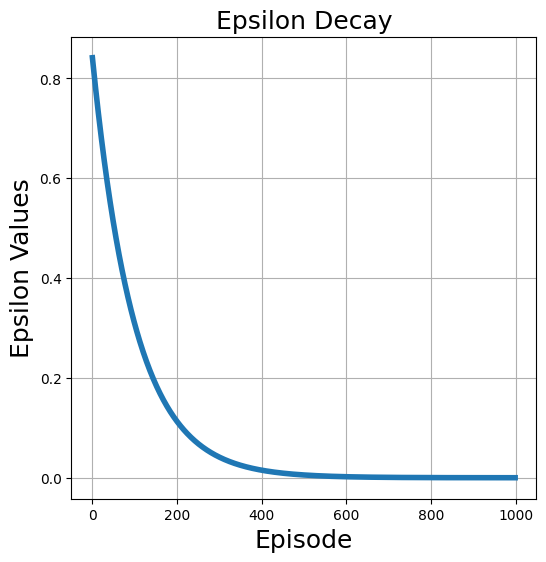

In [17]:
plt.figure(figsize=(6, 6))
plt.plot(epsilon_decay_list, linewidth=4)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Epsilon Values', fontsize=18)
plt.title('Epsilon Decay', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

## Setup 3

In [18]:
superMario2 = SuperMarioEnvironment()
SARSA_agent2 = SARSA(env= superMario2, discount_rate = configs[2]['discount_rate'], learning_rate = configs[2]['learning_rate'], epsilon= configs[2]['epsilon'])

reached, not_reached, total_reward = 0, 0, 0

epsilon_decay_list = []
episode_reward_list = []
episode_timestep_list = []

for each_episode in range(configs[2]['episodes']):
  
  state = superMario2.reset()[2]
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  action= SARSA_agent2.step(state = state)

  while not done:
    
    next_state, reward, done, info, _= superMario2.step(action = action)

    next_action= SARSA_agent2.step(state= next_state)

    SARSA_agent2.train(experience= (state, action, next_state, next_action, reward, done))
    state= next_state
    action= next_action

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1

  episode_timestep_list.append(timestep_per_episode)
  epsilon_decay_list.append(SARSA_agent2.epsilon)
  episode_reward_list.append(reward_per_episode)

  if done == True and superMario2.timestep < 50:
    reached += 1
  elif done == True and superMario2.timestep == 50:
    not_reached += 1

print('Goal Reached: {} & Goal Not reached: {}'.format(reached, not_reached))
     

Goal Reached: 1184 & Goal Not reached: 16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

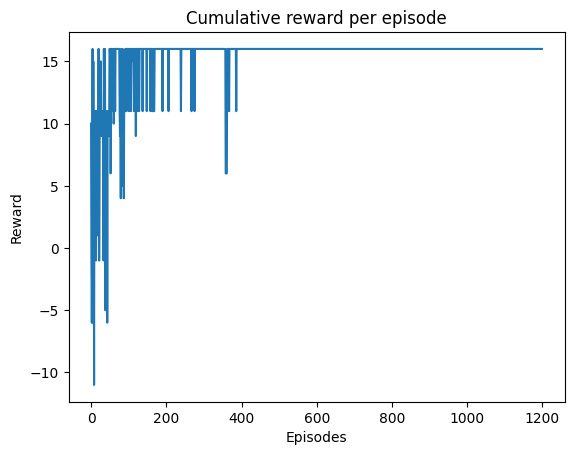

In [19]:
with output_grid.output_to(0, 0):
  plt.title('Cumulative reward per episode')
  plt.plot(episode_reward_list)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

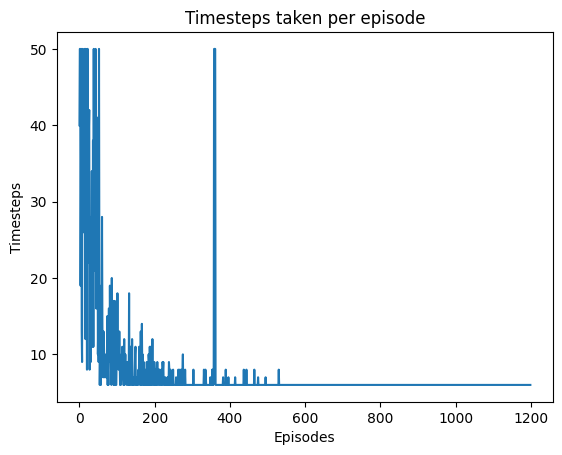

In [20]:
with output_grid.output_to(0, 0):
  plt.title('Timesteps taken per episode')
  plt.plot(episode_timestep_list)
  plt.xlabel('Episodes')
  plt.ylabel('Timesteps')

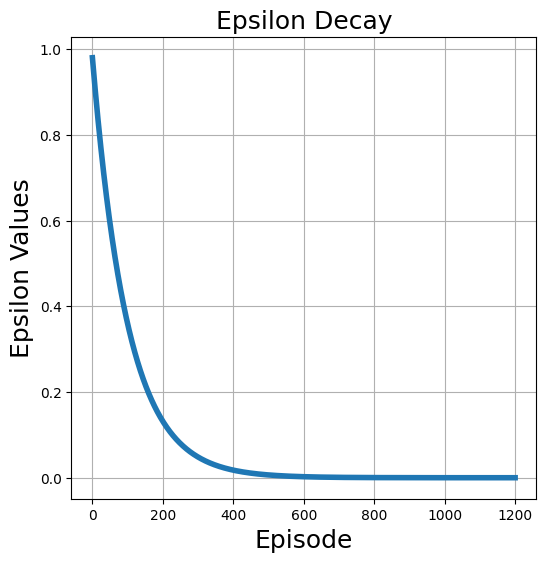

In [21]:
plt.figure(figsize=(6, 6))
plt.plot(epsilon_decay_list, linewidth=4)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Epsilon Values', fontsize=18)
plt.title('Epsilon Decay', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

## Part 3: Q-Learning

In [22]:
class QLearning(RandomAgent):
    
    def __init__(self, env, discount_rate, learning_rate, epsilon):
        super().__init__(env)

        self.epsilon= epsilon
        self.gamma= discount_rate
        self.alpha= learning_rate
        self.Q = np.zeros((self.observation_space.n, self.action_space.n))

    def step(self, state:int):
        Q_state= self.Q[state]
        greedy_action= np.argmax(Q_state)
        random_action= super().step(state)

        # Depending on the epsilon value greedy or random action is chosen
        return random_action if np.random.random() < self.epsilon else greedy_action

    def train(self, experience: tuple):
        state, action, next_state, next_action, reward, done = experience
        next_Q = self.Q[next_state, next_action]
        Q_value = reward + self.gamma * next_Q - self.Q[state, action]
        self.Q[state, action] += self.alpha * Q_value
        
        if done:
            self.epsilon *= 0.99


### Setup 1

In [23]:

superMario = SuperMarioEnvironment()
qlearn_agent = QLearning(env= superMario, discount_rate = configs[0]['discount_rate'], learning_rate = configs[0]['learning_rate'], epsilon= configs[0]['epsilon'])

reached, not_reached, total_reward = 0, 0, 0

epsilon_decay_list = []
episode_reward_list = []
episode_timestep_list = []

for each_episode in range(configs[0]['episodes']):
  
  state = superMario.reset()[2]
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  action= qlearn_agent.step(state = state)

  while not done:
    

    next_state, reward, done, info, _= superMario.step(action = action)

    next_action= qlearn_agent.step(state= next_state)

    qlearn_agent.train(experience= (state, action, next_state, next_action, reward, done))
    state= next_state
    action= next_action

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1

  episode_timestep_list.append(timestep_per_episode)
  epsilon_decay_list.append(qlearn_agent.epsilon)
  episode_reward_list.append(reward_per_episode)

  if done == True and superMario.timestep < 50:
    reached += 1
  elif done == True and superMario.timestep == 50:
    not_reached += 1

print('Goal Reached: {} & Goal Not reached: {}'.format(reached, not_reached))
     

Goal Reached: 494 & Goal Not reached: 6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

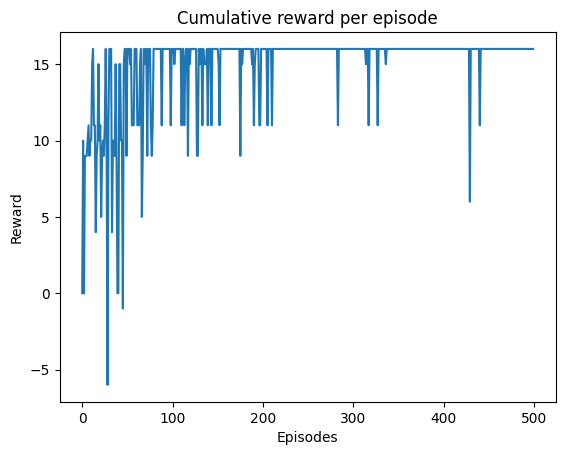

In [24]:
with output_grid.output_to(0, 0):
  plt.title('Cumulative reward per episode')
  plt.plot(episode_reward_list)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

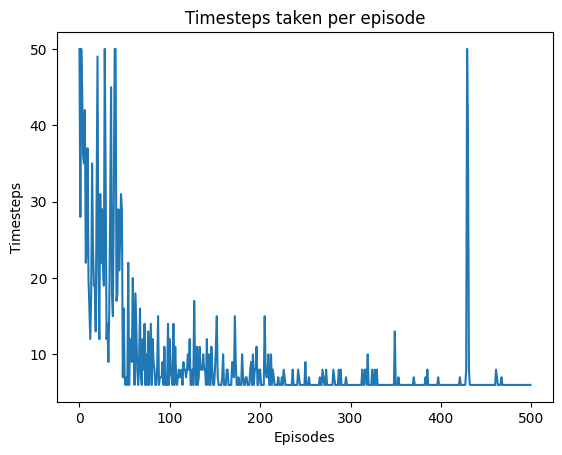

In [25]:
with output_grid.output_to(0, 0):
  plt.title('Timesteps taken per episode')
  plt.plot(episode_timestep_list)
  plt.xlabel('Episodes')
  plt.ylabel('Timesteps')

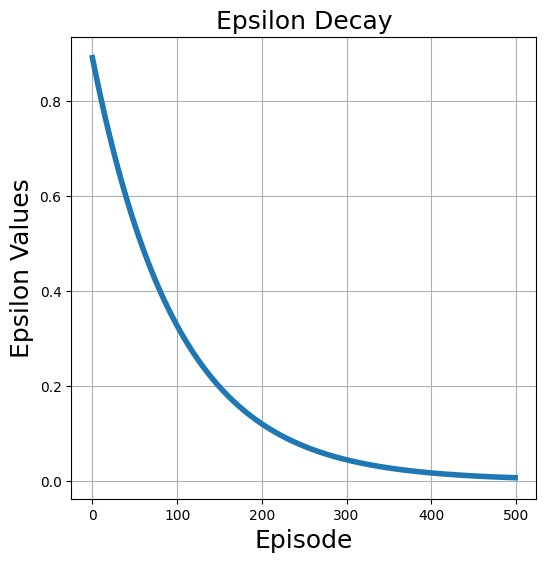

In [26]:
plt.figure(figsize=(6, 6))
plt.plot(epsilon_decay_list, linewidth=4)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Epsilon Values', fontsize=18)
plt.title('Epsilon Decay', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

### Setup 2

In [27]:

superMario = SuperMarioEnvironment()
qlearn_agent = QLearning(env= superMario, discount_rate = configs[0]['discount_rate'], learning_rate = configs[0]['learning_rate'], epsilon= configs[0]['epsilon'])

reached, not_reached, total_reward = 0, 0, 0

epsilon_decay_list = []
episode_reward_list = []
episode_timestep_list = []

for each_episode in range(configs[1]['episodes']):
  
  state = superMario.reset()[2]
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  action= qlearn_agent.step(state = state)

  while not done:
    

    next_state, reward, done, info, _= superMario.step(action = action)
    next_action= qlearn_agent.step(state= next_state)

    qlearn_agent.train(experience= (state, action, next_state, next_action, reward, done))
    state= next_state
    action= next_action

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1

  episode_timestep_list.append(timestep_per_episode)
  epsilon_decay_list.append(qlearn_agent.epsilon)
  episode_reward_list.append(reward_per_episode)

  if done == True and superMario.timestep < 50:
    reached += 1
  elif done == True and superMario.timestep == 50:
    not_reached += 1

print('Goal Reached: {} & Goal Not reached: {}'.format(reached, not_reached))
     

Goal Reached: 992 & Goal Not reached: 8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

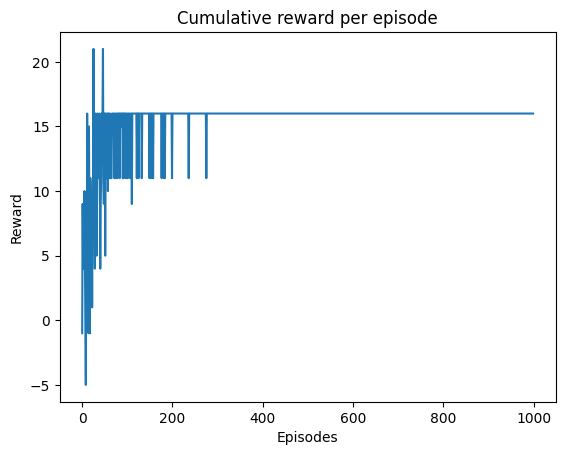

In [28]:
with output_grid.output_to(0, 0):
  plt.title('Cumulative reward per episode')
  plt.plot(episode_reward_list)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

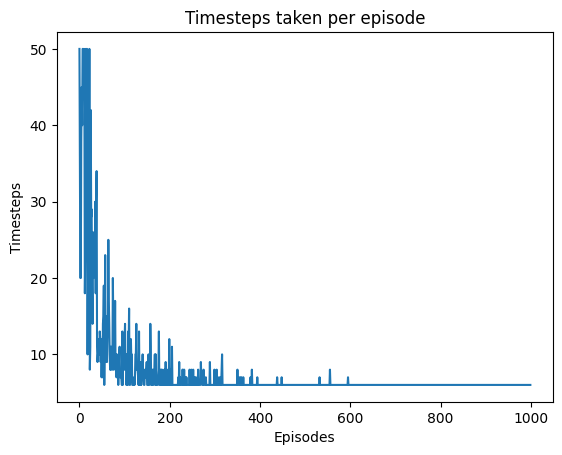

In [29]:
with output_grid.output_to(0, 0):
  plt.title('Timesteps taken per episode')
  plt.plot(episode_timestep_list)
  plt.xlabel('Episodes')
  plt.ylabel('Timesteps')

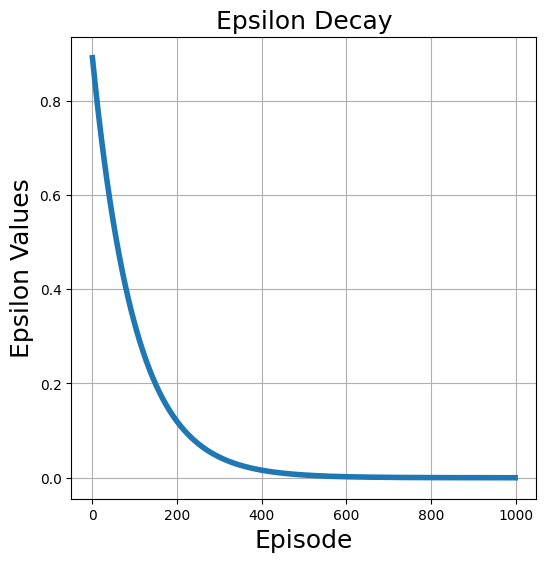

In [30]:
plt.figure(figsize=(6, 6))
plt.plot(epsilon_decay_list, linewidth=4)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Epsilon Values', fontsize=18)
plt.title('Epsilon Decay', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

### Setup 3

In [31]:

superMario = SuperMarioEnvironment()
qlearn_agent = QLearning(env= superMario, discount_rate = configs[0]['discount_rate'], learning_rate = configs[0]['learning_rate'], epsilon= configs[0]['epsilon'])

reached, not_reached, total_reward = 0, 0, 0

epsilon_decay_list = []
episode_reward_list = []
episode_timestep_list = []

for each_episode in range(configs[2]['episodes']):
  
  state = superMario.reset()[2]
  done= False
  reward_per_episode= 0
  timestep_per_episode= 0
  action= qlearn_agent.step(state = state)

  while not done:
    

    next_state, reward, done, info, _= superMario.step(action = action)
    next_action= qlearn_agent.step(state= next_state)

    qlearn_agent.train(experience= (state, action, next_state, next_action, reward, done))
    state= next_state
    action= next_action

    reward_per_episode += reward
    total_reward += reward
    timestep_per_episode += 1

  episode_timestep_list.append(timestep_per_episode)
  epsilon_decay_list.append(qlearn_agent.epsilon)
  episode_reward_list.append(reward_per_episode)

  if done == True and superMario.timestep < 50:
    reached += 1
  elif done == True and superMario.timestep == 50:
    not_reached += 1

print('Goal Reached: {} & Goal Not reached: {}'.format(reached, not_reached))
     

Goal Reached: 1195 & Goal Not reached: 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

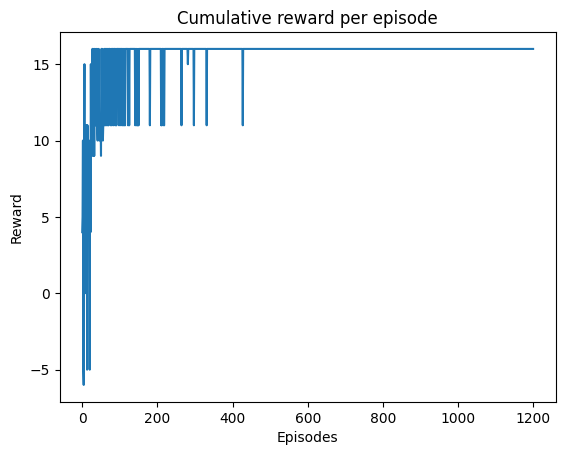

In [32]:
with output_grid.output_to(0, 0):
  plt.title('Cumulative reward per episode')
  plt.plot(episode_reward_list)
  plt.xlabel('Episodes')
  plt.ylabel('Reward')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

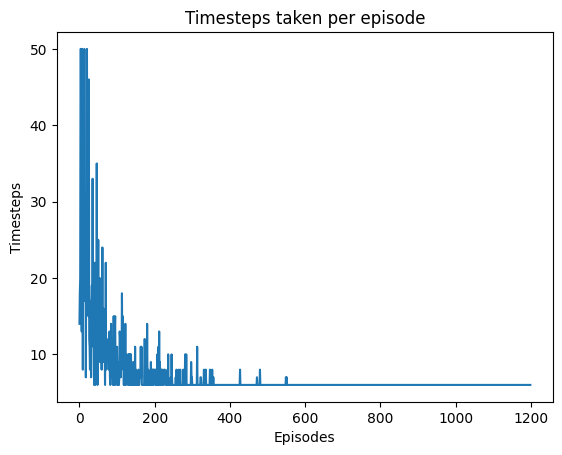

In [33]:
with output_grid.output_to(0, 0):
  plt.title('Timesteps taken per episode')
  plt.plot(episode_timestep_list)
  plt.xlabel('Episodes')
  plt.ylabel('Timesteps')

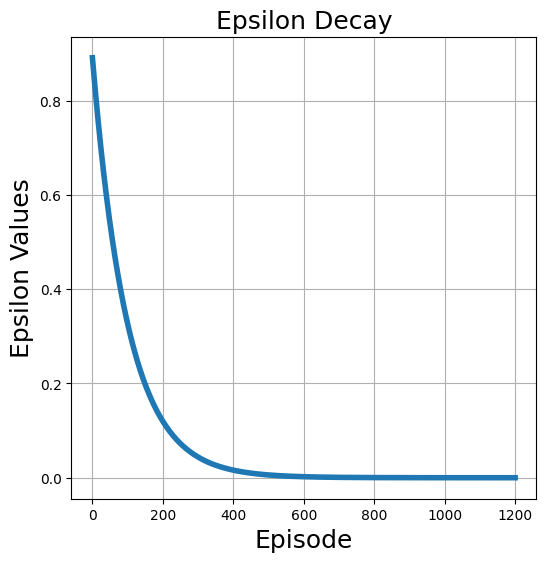

In [34]:
plt.figure(figsize=(6, 6))
plt.plot(epsilon_decay_list, linewidth=4)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Epsilon Values', fontsize=18)
plt.title('Epsilon Decay', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

# Referrences

1. Assignment_0 .ipynb file.
2. Assignment_1 .ipynb file.
3. Assignment_2 .ipynb file.
4. Pandas: "https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjPma_mton9AhU4EFkFHeExA0UQFnoECAoQAQ&url=https%3A%2F%2Fpandas.pydata.org%2F&usg=AOvVaw3cD5ulu4AnZcNusojIyttY"
5. Numpy: "https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjKp-mAt4n9AhWlK1kFHa5dD-MQFnoECBAQAQ&url=https%3A%2F%2Fnumpy.org%2F&usg=AOvVaw3L2i9HVc9ZeynETpNrPxO-"
6. Gymnasium: https://gymnasium.farama.org/
7. Optuna: https://optuna.org/